# Summary of Findings

### Author Contributions
 * Stephen Gelinas:
     * Baseline Model
     * Final Model
     * Fairness Evaluation
 * Romella Sagetellian:
     * Transformer Functions
     * Documentation

### Getting the Data
The data and its corresponding data dictionary is downloadable [here](https://www.propublica.org/datastore/dataset/civilian-complaints-against-new-york-city-police-officers).

Note: you don't need to provide any information to obtain the data. Just agree to the terms of use and click "submit."


### Introduction
A classifier was trained to predict whether or not an NYPD officer was disciplined after a complaint was
filed against them. For our target variable, we binarized the board disposition column into officers who were
disciplined after their complaint (1) and officers who weren't (0). We chose this target variable because we
wanted to see which features could have been responsible for an officer getting disciplinary action after having
a complaint filed against them. For our evaluation metric, we used the percent of predictions that were correct.
In this case, overall accuracy is the right metric to use because there is no extra harm in a false positive when
compared to a false negative result, especially since our dataset is not class-imbalanced. Both mistakes will be
weighed the same in our accuracy model.

### Baseline Model
The baseline model has 9 features: 2 that are quantitative, 1 that is ordinal, and 6 that are nominal. As stated in
the introduction, for our evaluation metric we used the % accuracy and with our baseline model we got 74.40%
accuracy, which was not good because this is about the same accuracy (if not lower) than if we had an extreme
model that just guessed 0 (no disciplinary action taken) each time which had 75.81% accuracy.

### Final Model
The features we added were the age difference between the officer and the complainant and also the duration
that each complaint was open. For the age difference between the officer and the complainant, we chose to add
this because not only did it combine the information for 2 columns that were in the original data (the age of the
complainant and the age of the officer), we felt like it would be more likely for someone to file a complaint if the
violating officer was younger than them or close to them in age. In this type of situation, the complainant might
feel like they have more authority over the police officer than if the complainant was much younger than their
arresting officer. As for the complaint duration, we felt like this would positively impact our model because cases
that were closed faster were likely taken more seriously than those that were open for longer periods of time
because they were investigated immediately and we felt like this would also reflect itself in the disciplinary
actions agasint the violating officers.
For our model we chose a Decision Tree Classifier because almost all of our features were categorical. For
parameters that worked best with our model, running grid search showed that the ideal max_depth parameter
was 20 and the ideal min_samples_leaf parameter was 10.

### Fairness Evaluation
An'interesting subset' we analyzed was the column containing each police officer's rank at the time the
complaint was closed and we binarized it based on whether the police officer's rank was just a regular police
officer (the lowest possible rank in the NYPD) (True) or whether the officer's rank was higher (False). We wanted
to see whether our model was fairer towards regular police officers or their superiors. The reason we chose this
column was because it was the most important feature in our model when making predictions.
For our parity measure, we picked accuracy because we noticed that our model's predictions for officers who
were disciplined were artificially low, so we wanted to see whether this held true for all ranking officers. These
were our hypotheses:

* **Null Hypothesis:** the classifier is fair; the precision for cops with the rank 'Police Officer' and for cops who don't have the rank 'Police Officer' is the same


* **Alternative Hypothesis:** the classifier is unfair; the precision for the cops with the rank 'Police Officer' is different than the precision for cops who don't have the rank 'Police Officer'

From here, we ran a permutation test at the 0.05 significance level to see whether we reject or fail to reject the
null hypothesis. We ended up with a p-value of 0.0, meaning that we reject our null hypothesis and predict that
the classifier is fair towards cops with the rank 'Police Officer'.

# Code

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Higher resolution figures

In [4]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

Functions to be used by transformers for both baseline and final model:

In [5]:
def unknown_cleaner(x):
    if x in ['Unknown', 'Refused', 'Not described', 'Other', 'Others',
'No contact']: return 'Unknown'
    else: return x
    
def outcome_ordinal(df):
    if type(df)!=pd.core.frame.DataFrame: df = pd.DataFrame(df)
    def ord_helper(x):
        x = x.lower()
        if 'no arrest' in x: return 0
        elif ('parking' in x) or ('moving' in x): return 1
        elif ('summons' in x) or ('juvenile' in x): return 2
        else: return 3
    d = df.applymap(ord_helper)
    return d

def disposition_ordinal(df):
    if type(df)!=pd.core.frame.DataFrame: df = pd.DataFrame(df)
    def ord_helper(x):
        x = x.lower()
        if 'unsubstantiated' in x: return 0
        elif 'exonerated' in x: return 1
        else: return 2
    d = df.applymap(ord_helper)
    return d
    
def age_difference(df):
    diff = df[:,0] - df[:,1]
    return np.reshape(diff, (-1,1))

def rank_ordinal(df):
    if type(df)!=pd.core.frame.DataFrame: df = pd.DataFrame(df)
    def ord_helper(x):
        x = x.lower()
        if 'police officer' in x: return 0
        elif 'detective' in x: return 1
        elif 'sergeant' in x: return 2
        elif 'lieutenant' in x: return 3
        elif 'captain' in x: return 4
        elif 'inspector' in x and ' ' not in x: return 5
        elif 'deputy' in x: return 6
        else: return 7
    d = df.applymap(ord_helper)
    return d

### Baseline Model

In [6]:
df = pd.read_csv('nypd.csv')
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


In [7]:
#determine if action was taken after complaint against officer
def engineer_outcome(df):
    def ord_helper(x):
        x = x.lower()
        if 'unsubstantiated' in x or 'exonerated' in x: return 0
        else: return 1
    d = df.apply(ord_helper)
    return d

#outcome engineered to whether action was taken against the officer
df['action_taken'] = engineer_outcome(df['board_disposition'])

#drop unnecessary columns
df = df.drop(columns = ['unique_mos_id', 'first_name', 'last_name', 'shield_no',
                        'complaint_id', 'precinct', 'command_now', 
                        'command_at_incident', 'rank_abbrev_incident',
                        'rank_abbrev_now','rank_incident','allegation', 'board_disposition',
                        ])

#clean unknown gender, ethnicity, age etc. and drop na rows
df = df.dropna(axis = 0)

#split data into response and explanatory variables
X = df.drop(columns=['action_taken'])
y = df['action_taken']

In [32]:
#create pipeline for baseline model
ohe_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')
cat_transformer = Pipeline(steps=[('encode', ohe_transformer),
                                 ('pca', PCA(svd_solver = 'full'))])
outcome_transformer = FunctionTransformer(outcome_ordinal, validate = False)
rank_transformer = FunctionTransformer(rank_ordinal, validate = False)

preproc = ColumnTransformer(transformers=[\
                        ('categorical', cat_transformer, ['complainant_ethnicity', 'complainant_gender',
                                                          'mos_ethnicity', 'mos_gender', 'fado_type']),
                        ('rank', rank_transformer, ['rank_now']),
                        ('outcome', outcome_transformer, ['outcome_description'])
                        ], remainder = 'drop')

pl = Pipeline(steps=[
                     ('preprocessing', preproc), \
                     ('predictions', RandomForestClassifier())\
                    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
pl.fit(X_train, y_train)
preds = pl.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.738898756660746

In [9]:
np.mean(0==y_test)

0.7525162818235642

In [10]:
#model is actually worse than guessing 0 every time

### Final Model

In [31]:
#determine most important features for classification from baseline model
trans = pl.named_steps['preprocessing'].transformers_
cols = trans[0][1].named_steps['encode'].get_feature_names(['complainant_ethnicity', 'complainant_gender',
                                                          'mos_ethnicity', 'mos_gender', 'fado_type'])
original_cols = np.array(['rank_now', 'outcome_description'])
for i in original_cols:
    cols = np.append(cols, i)

#most important features
clf = pl.named_steps['predictions']
pd.Series(
    data = clf.feature_importances_,
    index = cols
).sort_values(ascending = False)

rank_now                                    0.295484
outcome_description                         0.233820
complainant_ethnicity_Asian                 0.069022
complainant_ethnicity_Refused               0.052446
complainant_gender_Male                     0.031366
complainant_ethnicity_Black                 0.029046
complainant_ethnicity_Hispanic              0.027640
complainant_gender_Not described            0.027577
complainant_ethnicity_White                 0.022403
complainant_gender_Transwoman (MTF)         0.019174
mos_ethnicity_American Indian               0.017379
complainant_gender_Female                   0.017120
mos_ethnicity_Hispanic                      0.017032
mos_ethnicity_Asian                         0.016661
complainant_ethnicity_Unknown               0.016592
mos_gender_F                                0.016350
complainant_gender_Gender non-conforming    0.015955
mos_ethnicity_White                         0.015947
complainant_gender_Transman (FTM)           0.

In [12]:
#some features added are just noise, like the fado_type, mos_gender, mos_ethnicity, possible colinearities from OHE

In [13]:
#PCA
params = {
    'preprocessing__categorical__pca__n_components': [.05, .1, .15, .2, .25, .3]
}
grids = GridSearchCV(pl, param_grid = params, cv = 3)
grids.fit(X_train, y_train)
print('PCA results: ', grids.best_params_)
print('Best score after PCA: ', grids.best_score_)

PCA results:  {'preprocessing__categorical__pca__n_components': 0.25}
Best score after PCA:  0.740357287860333


In [14]:
#from PCA on categorial columns, we can see that these features aren't very important for predicting whether a
#police officer is disciplined from a complaint. We'd opt for a simpler model by reducing the number of components
#to about 10% of the original data, after one hot encoding the categorical features

In [15]:
#feature engineering complaint duration and age difference
def duration(df):
    cols = df.columns
    year_closed = df[cols[0]]
    year_received = df[cols[1]]
    month_closed = df[cols[2]]
    month_received = df[cols[3]]
    temp = (year_closed-year_received)*12+(month_closed-month_received)
    return pd.DataFrame(temp)

def age_difference(df):
    if type(df)!=pd.core.frame.DataFrame: df = pd.DataFrame(df)
    cols = df.columns
    officer_age = df[cols[0]].apply(lambda x: 0 if abs(x) > 400 else x)
    complainant_age = df[cols[1]].apply(lambda x: 0 if abs(x) > 400 else x)
    diff = officer_age - complainant_age
    return pd.DataFrame(diff)

In [16]:
#determine if model has improved from PCA, feature engineering, and feature selection
ohe_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')
cat_transformer = Pipeline(steps=[('encode', ohe_transformer),
                                  ('pca', PCA(svd_solver = 'full', n_components = .2))])
rank_transformer = FunctionTransformer(rank_ordinal, validate = False)
outcome_transformer = FunctionTransformer(outcome_ordinal, validate = False)
age_transformer = Pipeline(steps=[('diff', FunctionTransformer(age_difference)),
                                  ('standardize', StandardScaler())])
duration_transformer = Pipeline(steps=[('duration', FunctionTransformer(duration)),
                                       ('standardize', StandardScaler())])

preproc = ColumnTransformer(transformers=[\
                        ('categorical', cat_transformer, ['complainant_gender', 'complainant_ethnicity']),
                        ('rank', rank_transformer, ['rank_now']),
                        ('outcome', outcome_transformer, ['outcome_description']),
                        ('age', age_transformer, ['mos_age_incident', 'complainant_age_incident']),
                        ('duration', duration_transformer, ['year_closed', 'year_received',
                                                           'month_closed','month_received']),
                        ], remainder = 'drop')

pl2 = Pipeline(steps=[
                     ('preprocessing', preproc), \
                     ('predictions', RandomForestClassifier())\
                    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
pl2.fit(X_train, y_train)
preds2 = pl2.predict(X_test)
metrics.accuracy_score(y_test, preds2)

0.7529899348727057

In [17]:
#cross validation on engineered model
parameters = {
    'predictions__min_samples_leaf': [2,4,6,8,10,12],
    'predictions__max_depth': [2,5,10,15,20],
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf = GridSearchCV(pl2, parameters, cv = 3)
clf.fit(X_train,y_train)
print('best parameters: ', clf.best_params_)
print('highest % accuracy using grid search determined best parameters: ', clf.best_score_)
print('% accuracy if our model guessed 0 every time: ', np.mean(y_test== 0))

best parameters:  {'predictions__max_depth': 15, 'predictions__min_samples_leaf': 6}
highest % accuracy using grid search determined best parameters:  0.7586276898091757
% accuracy if our model guessed 0 every time:  0.754647720544701


In [19]:
#final model
pl_final = Pipeline(steps=[
                     ('preprocessing', preproc), \
                     ('predictions', RandomForestClassifier(max_depth = 15,
                                                           min_samples_leaf = 4))\
                    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
pl_final.fit(X_train, y_train)
preds_final = pl_final.predict(X_test)
print('% accuracy of the final model: ', metrics.accuracy_score(y_test, preds_final))
print('% accuracy if our model guessed 0 every time: ', np.mean(0==y_test))

% accuracy of the final model:  0.7622261693309651
% accuracy if our model guessed 0 every time:  0.7538188277087033


In [ ]:
#our model is finally above baseline guessing now using PCA, cross validation, and feature selection

### Fairness Evaluation

When analyzing if the built model for classifying whether a complaint made against an NYPD officer leads to disciplinary action is fair across specific demographics, we must take a deeper look into the classifier's performance and where it underperforms.

In [20]:
def determine_outcome(df):
    def helper(x):
        if x[0] == 0 and x[1] == 0:
            return 'TN'
        elif x[0] == 1 and x[1] == 1:
            return 'TP'
        elif x[0] == 1 and x[1] == 0:
            return 'FP'
        else:
            return 'FN'
    return df.apply(helper, axis = 1)

pred_analysis = pd.DataFrame(preds_final, columns = ['prediction'])
pred_analysis['test_label'] = y_test.reset_index()['action_taken']  
out = determine_outcome(pred_analysis)
pred_analysis['outcome'] = out
pred_analysis.head()

,prediction,test_label,outcome
0,0,0,TN
1,0,0,TN
2,0,0,TN
3,0,1,FN
4,0,0,TN


Plotting a confusion matrix will help us determine the proportion of true negative, false positive, false negative, and true positive classifications from our model. From the confusion matrix, we can see that the classifier has a true negative rate of about 73.6%, a false positive rate of about 1.6%, a false negative rate of about 22.1% and a true positive rate of about 2.5%. The model tends to underperform when making positive classifications.

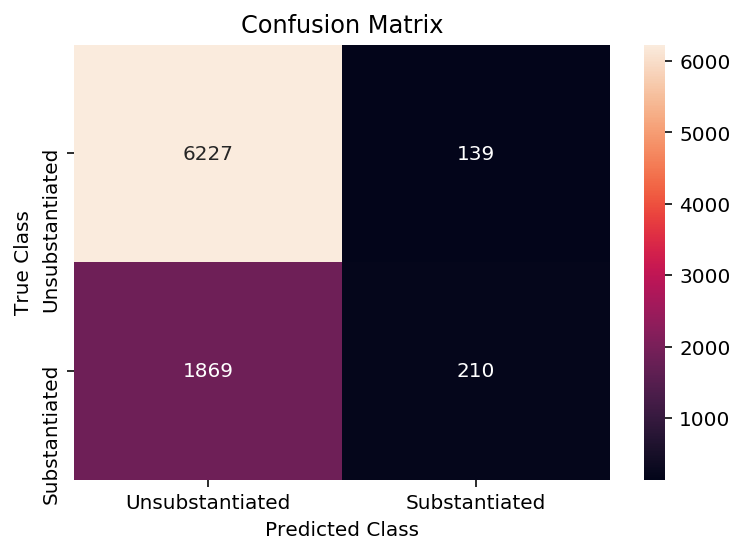

In [29]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds_final).ravel()
#plot confusion matrix
cm = metrics.confusion_matrix(y_test, preds_final)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['Unsubstantiated', 'Substantiated'])
ax.yaxis.set_ticklabels(['Unsubstantiated', 'Substantiated'])
plt.show()

Analyzing the model's recall, specificity, and precision, we can see that the classifier has a recall rate of 10.4%, which is the proportion of NYPD officers who were correctly identified as disciplined from a complaint. The classifier has a specificity rate of 97.8%, which is the proportion of NYPD officers who were correctly identified as not being disciplined from a complaint. Finally, the classifier has a precision rate of 6.1%, which is the proportion of NYPD officers classified as being disciplined from a complaint that were actually disciplined.

In [22]:
recall = metrics.recall_score(y_test, preds_final)
specificity = metrics.recall_score(y_test, preds_final, pos_label = 0)
precision = metrics.precision_score(y_test, preds_final)

print("Recall: " + str(recall) + '\n'
     +"Specificity: " + str(specificity) + '\n'
     +"Precision: " + str(precision))

Recall: 0.10101010101010101
Specificity: 0.9781652529060635
Precision: 0.6017191977077364


The officer's rank was the most important feature in predicting whether an NYPD officer was disciplined following a complaint. When analyzing the parity of the classifier based on the officer's rank, it appears that the model predicts complaints made against NYPD cops with the rank 'Police Officer' are more likely to result in disciplinary action compared to complaints made against NYPD cops who aren't the rank 'Police Officer.'

In [23]:
results = X_test.copy()
results['preds'] = preds_final
results['actual'] = y_test
results['regular_officer'] = results['rank_now'].map(lambda x: True if x == 'Police Officer' else False)
results.groupby('regular_officer')['preds'].mean()

regular_officer
False    0.022926
True     0.079824
Name: preds, dtype: float64

When analyzing accuracy parity between cops with the rank 'Police Officer' and all other cops, there appears to be accuracy parity. The classifier performs worse when the officer's rank is 'Police Officer' and there is an observed accuracy difference of about 8%. To test if this difference is significant, a permutation test will be conducted.

In [24]:
regular_officers = results.groupby('regular_officer').apply(lambda x: metrics.accuracy_score(x.actual, x.preds)).rename('accuracy').to_frame()
regular_officers

,accuracy
regular_officer,
False,0.787014
True,0.710363


<b>Null Hypothesis:</b> the classifier is fair; the precision for cops with the rank 'Police Officer' and for cops who don't have the rank 'Police Officer' is the same

<b>Alternative Hypothesis:</b> the classifier is unfair; the precision for the cops with the rank 'Police Officer' is different than the precision for cops who don't have the rank 'Police Officer'

In [25]:
obs = regular_officers.diff().iloc[-1].to_numpy()
accuracy_diffs = []
for i in range(200):
    s = (
        results[['regular_officer', 'preds', 'actual']]
        .assign(regular_officer=results.regular_officer.sample(frac = 1.0, replace = False).reset_index(drop=True))
        .groupby('regular_officer')
        .apply(lambda x: metrics.accuracy_score(x.actual, x.preds))
        .diff()
        .iloc[-1]
    )
    accuracy_diffs.append(s)

np.mean(obs >= accuracy_diffs)

0.0

A p-value of 0.0 was obtained, so we reject the null hypothesis that the classifier is fair for cops whose rank is 'Police Officer' and for all other cops, a significance level of alpha = 0.01. We have convincing evidence that our classifier is unfair for these two subgroups, and that accuracy parity doesn't exist.

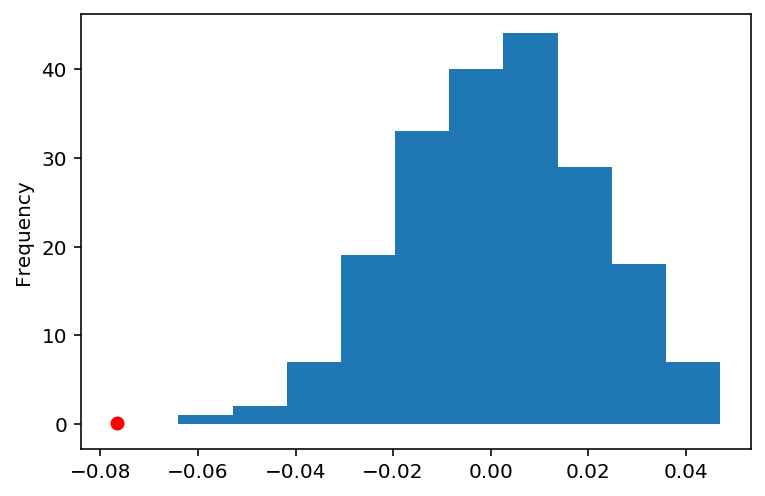

In [26]:
pd.Series(accuracy_diffs).plot(kind = 'hist')
plt.scatter(obs, 0.1, c ='r');